In [1]:
from scipy import stats
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import pandas as pd
from theano import shared
from sklearn import preprocessing

print('Running on PYMC3 v {}'.format(pm.__version__))

Running on PYMC3 v 3.6


In [2]:
# Read the data
data = pd.read_csv('renfe.csv')
data.head(3)

,Unnamed: 0,insert_date,origin,destination,start_date,end_date,train_type,price,train_class,fare
0,0,2019-04-19 05:31:43,MADRID,SEVILLA,2019-05-29 06:20:00,2019-05-29 09:16:00,AV City,38.55,Turista,Promo
1,1,2019-04-19 05:31:43,MADRID,SEVILLA,2019-05-29 07:00:00,2019-05-29 09:32:00,AVE,53.40,Turista,Promo
2,2,2019-04-19 05:31:43,MADRID,SEVILLA,2019-05-29 07:30:00,2019-05-29 09:51:00,AVE,47.30,Turista,Promo


In [3]:
#Drop the Unnamed column
data.drop('Unnamed: 0', axis = 1, inplace=True)
data = data.sample(frac =0.01,random_state=99)

data.head(3)

,insert_date,origin,destination,start_date,end_date,train_type,price,train_class,fare
420104,2019-04-22 08:00:25,MADRID,SEVILLA,2019-04-28 08:30:00,2019-04-28 11:14:00,ALVIA,NaN,Turista,Flexible
431888,2019-04-22 10:03:24,MADRID,VALENCIA,2019-05-20 06:45:00,2019-05-20 08:38:00,AVE,21.95,Turista,Promo
791293,2019-04-25 19:19:46,MADRID,SEVILLA,2019-05-29 06:20:00,2019-05-29 09:16:00,AV City,38.55,Turista,Promo


In [4]:
data.isnull().sum()/len(data)

insert_date    0.000000
origin         0.000000
destination    0.000000
start_date     0.000000
end_date       0.000000
train_type     0.000000
price          0.119467
train_class    0.003993
fare           0.003993
dtype: float64

As we can see the price column has 12% values which are null. We can fill those by mean of the respective fares

In [5]:
data['train_class'] = data['train_class'].fillna(data['train_class'].mode().iloc[0])
data['fare'] = data['fare'].fillna(data['fare'].mode().iloc[0])
data['price'] = data.groupby('fare').transform(lambda x: x.fillna(x.mean()))

In [6]:
data.isnull().sum()/len(data)

insert_date    0.0
origin         0.0
destination    0.0
start_date     0.0
end_date       0.0
train_type     0.0
price          0.0
train_class    0.0
fare           0.0
dtype: float64

([<matplotlib.axis.YTick at 0x1c1dff4f98>],
 <a list of 1 Text yticklabel objects>)

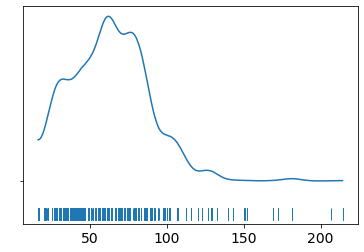

In [7]:
az.plot_kde(data['price'].values, rug= True)
plt.yticks([0], alpha =0)

The KDE plot of price looks like Gaussian-like distribution except for several dozen of data points that are far away from mean

Model Specifications :
    Choices of Prior = 
        μ: mean of the population, Normal Distriibution very wide.set priors reflecting on your knowledge:
            may 0 to 400 for the ticket prices in general
        σ: Standard Deviation of the popultion can only be +ve so use HalfNormal distribution
    Choices for ticket price likelihood funciton:
        y: observed variable representing the data that comes from normal distibution with parameters σ and μ
        
   
   The Y Specifies the likelihood.This is the way we tell pYMC3 that we want to condition for the unknown on the known.
        

In [8]:
with pm.Model() as model_g:
    μ = pm.Uniform('μ', lower=0, upper=300)
    σ = pm.HalfNormal('σ', sd=10)
    y = pm.Normal('y', mu=μ, sd=σ, observed=data['price'].values)
    trace_g = pm.sample(1000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, μ]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:05<00:00, 735.85draws/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c1efba320>,
      dtype=object)

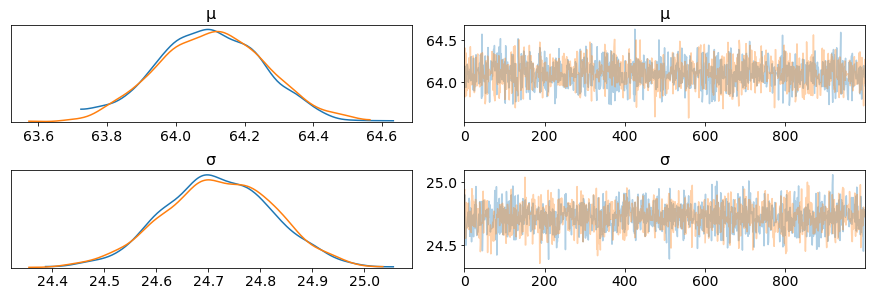

In [9]:
az.plot_trace(trace_g)

Couple of things to Notice:
    1) Our Sampling chains for the individual parameters seems well converged and stationary
    2) The maximum posterior estimate of each variable is very close to the true parameters

(<matplotlib.axes._subplots.AxesSubplot at 0x1c20f20320>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1c201ede80>)

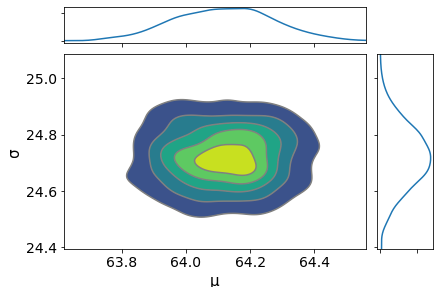

In [17]:
az.plot_joint(trace_g, kind='kde', fill_last= False)

In [18]:
az.summary(trace_g)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
μ,64.114,0.156,63.826,64.410,0.004,0.003,1494.0,1494.0,1493.0,1233.0,1.01
σ,24.720,0.110,24.512,24.926,0.003,0.002,1739.0,1739.0,1737.0,1312.0,1.00


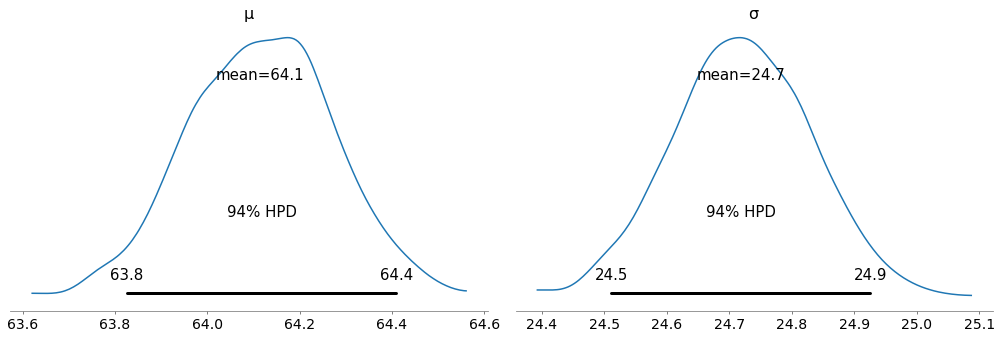

In [19]:
az.plot_posterior(trace_g);

In [20]:
pm.gelman_rubin(trace_g)


{'μ': 0.9996495990972428, 'σ': 0.9995391942529478}

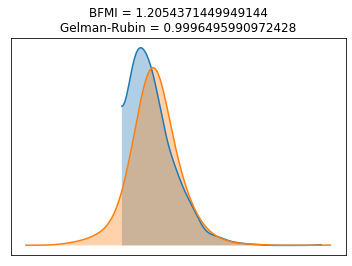

In [21]:
bfmi = pm.bfmi(trace_g)
max_gr = max(np.max(gr_stats) for gr_stats in pm.gelman_rubin(trace_g).values())
(pm.energyplot(trace_g, legend=False, figsize=(6, 4)).set_title("BFMI = {}\nGelman-Rubin = {}".format(bfmi, max_gr)));

Posterior Predictive Checks (PPC) - are a great way to evalaute a model. The idea is to generate data from the model using parameters drawn from the posterior.


In [25]:
#Randomly draw 1000 samples of the parameters from the trace
ppc = pm.sample_posterior_predictive(trace_g, samples=1000, model = model_g)
np.asarray(ppc['y']).shape



100%|██████████| 1000/1000 [00:03<00:00, 321.34it/s]


(1000, 25798)

[Text(0, 0.5, 'Frequency'),
 Text(0.5, 0, 'mean(x)'),
 Text(0.5, 1.0, 'Posterior predictive of the mean')]

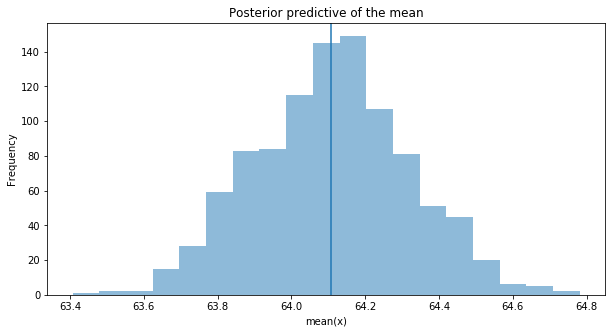

In [28]:
_, ax = plt.subplots(figsize=(10, 5))
ax.hist([y.mean() for y in ppc['y']], bins = 19, alpha=0.5)
ax.axvline(data.price.mean())
ax.set(title = 'Posterior predictive of the mean', xlabel = 'mean(x)', ylabel='Frequency')

The Inferred mean is very close to the actual ticket Price.

Group Comparison
We may be interested in how price compare under different fare types.
we are going to focus on estimating the effect size, that is, 
quantifying the difference between two fare types. 
To compare fare types, we are going to use the mean of each fare type.
Because we are Bayesian, we will work to obtain a posterior distribution of the differences of means 
between fare types

In [35]:
price = data['price'].values
idx = pd.Categorical(data['fare'],categories=['Flexible','Promo', 'Promo +', 'Adult to ida', 'Mesa','Individual-Flexible']).codes
groups = len(np.unique(idx))

In [36]:
print(np.unique(idx))

[-1  0  1  2  4  5]


The model for the group comparison problem is almost the same as the previous model. the only difference is that μ and σ are going to be vectors instead of scalar variables. This means that for the priors, we pass a shape argument and for the likelihood, we properly index the means and sds variables using the idx variable:

In [39]:
with pm.Model() as comparing_groups:
    μ = pm.Normal('μ', mu=0, sd=10, shape=groups)
    σ = pm.HalfNormal('σ', sd=10, shape=groups)

    y = pm.Normal('y', mu=μ[idx], sd=σ[idx], observed=price)

    trace_groups = pm.sample(5000, tune=5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, μ]
Sampling 2 chains: 100%|██████████| 20000/20000 [04:37<00:00, 72.19draws/s] 
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


In [ ]:
az.plot_trace(trace_groups);
flat_fares = az.from_pymc3(trace=trace_groups)
fares_gaussian = az.summary(flat_fares)
fares_gaussian

In [ ]:
dist = stats.norm()

_, ax = plt.subplots(5, 2, figsize=(20, 12), constrained_layout=True)

comparisons = [(i, j) for i in range(6) for j in range(i+1, 6)]
pos = [(k, l) for k in range(5) for l in (0, 1)]

for (i, j), (k, l) in zip(comparisons, pos):
    means_diff = trace_groups['μ'][:, i] - trace_groups['μ'][:, j]
    d_cohen = (means_diff / np.sqrt((trace_groups['σ'][:, i]**2 + trace_groups['σ'][:, j]**2) / 2)).mean()
    ps = dist.cdf(d_cohen/(2**0.5))
    az.plot_posterior(means_diff, ref_val=0, ax=ax[k, l])
    ax[k, l].set_title(f'$\mu_{i}-\mu_{j}$')
    ax[k, l].plot(
        0, label=f"Cohen's d = {d_cohen:.2f}\nProb sup = {ps:.2f}", alpha=0)
    ax[k, l].legend();